In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime
import keyboard
import torch.nn.functional as F

# Function to select action based on policy
def select_action(actor, state):
    with torch.no_grad():
        state = torch.tensor(state, dtype=torch.float32)
        mean, std = actor(state)
        dist = torch.distributions.Normal(mean, std)
        # 重采样，直到动作在范围内
        while True:
            action = dist.sample()
            if -2.0 <= action <= 2.0:
                break
        # 修正动作概率
        cdf_min = dist.cdf(torch.tensor(-2.0, dtype=torch.float32))
        cdf_max = dist.cdf(torch.tensor(2.0, dtype=torch.float32))
        normalization_constant = (cdf_max - cdf_min).clamp(min=1e-6)  # 避免数值问题
        log_prob = (dist.log_prob(action) - torch.log(normalization_constant)).sum()
        # 计算熵
        normal_entropy = dist.entropy().sum()
        truncated_entropy = normal_entropy / normalization_constant + torch.log(normalization_constant).sum()
        return action.numpy(), log_prob

def select_action_clamp(actor, state):
    with torch.no_grad():
        state = torch.tensor(state, dtype=torch.float32)
        mean, std = actor(state)
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample()#.clamp(-2.0, 2.0)  # 限制动作范围在[-2, 2]之间
        # 修正概率
        log_prob = dist.log_prob(action)
        cdf_min = dist.cdf(torch.tensor(-2.0, dtype=torch.float32))
        cdf_max = dist.cdf(torch.tensor(2.0, dtype=torch.float32))
        if action <= -2.0:
            log_prob = torch.log(cdf_min)
            action = torch.tensor(-2.0)
        elif action >= 2.0:
            log_prob = torch.log(1.0 - cdf_max)
            action = torch.tensor(2.0)
        return action.numpy(), log_prob.sum()

# 贪心策略选择动作
def select_greedy_action(actor, state):
    with torch.no_grad():
        state = torch.tensor(state, dtype=torch.float32)
        mean, _ = actor(state)
        return mean.detach().numpy()


<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


Environment: Pendulum-v1
State space: 3 dimensions
Action space: 1 actions
Reward threshold: None
Maximum episode steps: 200


c:\Users\Windows11\anaconda3\envs\py310_torch\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Steps: 2000


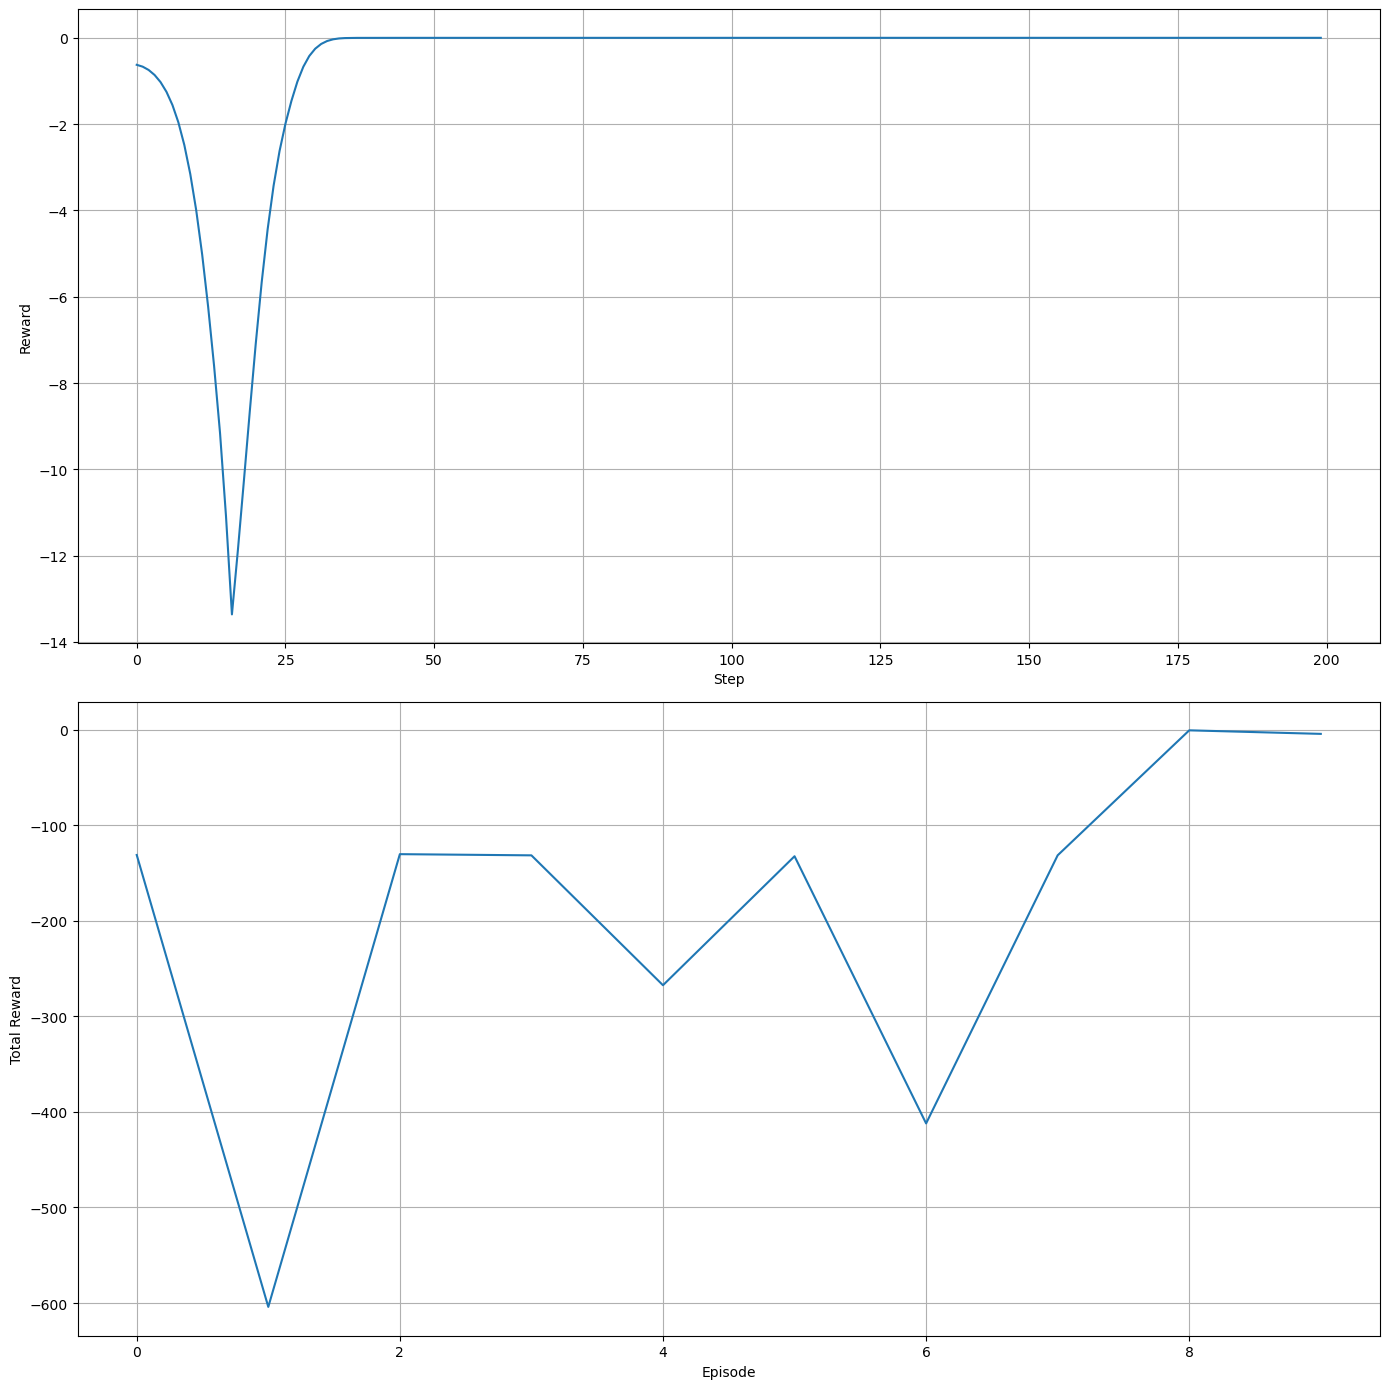

In [2]:
import gym
import time
import pygame
from A3C_Network import Actor, Critic

# Test the trained model
def test_actor_critic(env_name="Pendulum-v1", max_episodes=10):
    
    # Initialize environment
    env = gym.make(env_name, render_mode="human") # render_mode="human"表示使用pygame进行渲染
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    print(f"Environment: {env_name}")
    print(f"State space: {state_dim} dimensions")
    print(f"Action space: {action_dim} actions")
    print(f"Reward threshold: {env.spec.reward_threshold}")
    print(f"Maximum episode steps: {env.spec.max_episode_steps}")

    # Initialize networks and optimizers
    actor_net = Actor(state_dim, action_dim)
    actor_net.load_state_dict(torch.load(env_name + '_SA3C_PPO-actor.pth', weights_only=True)) # 加载训练好的actor网络
    actor_net.eval()
    state = env.reset()
    state = state[0]
    step = 0
    episode = 0
    bExit = False
    rewards = []
    rewards_history = []
    total_rewards = []

    while bExit == False and episode < max_episodes:
        #env.render()
        # 帧率控制
        #time.sleep(1/30)
        
        # 贪婪策略选择动作
        action = select_greedy_action(actor_net, state)
        #action, _ = select_action(actor_net, state)
        state, reward, terminated, truncated, _ = env.step(action)
        step += 1
        rewards.append(reward)

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                env.close()
                bExit = True
            # 按下esc键退出
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_ESCAPE:
                    env.close()
                    bExit = True
        if terminated or truncated:
            episode += 1
            total_rewards.append(sum(rewards))
            rewards_history.append(rewards)
            rewards = []
            state = env.reset()[0]

    env.close()
    print(f"Steps: {step}")
    #print(f"Total Reward: {sum(rewards)}")

    # 调整图像大小
    plt.figure(figsize=(14, 14))
    # 绘制奖励曲线
    plt.subplot(2, 1, 1)
    plt.plot(rewards_history[0])
    plt.xlabel('Step')
    plt.ylabel('Reward')
    # 网格线
    plt.grid(True)

    # 绘制总奖励曲线
    plt.subplot(2, 1, 2)
    plt.plot(total_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    # 网格线
    plt.grid(True)

    # 调整布局并显示图像
    plt.tight_layout()
    plt.show()

    return total_rewards, rewards_history
%matplotlib inline
total_rewards, rewards_history = test_actor_critic(env_name="Pendulum-v1")

In [3]:
# 绘制奖励曲线
%matplotlib qt
plt.plot(rewards_history[0])
plt.xlabel('Step')
plt.ylabel('Reward')
# 网格线
plt.grid(True)
plt.show()

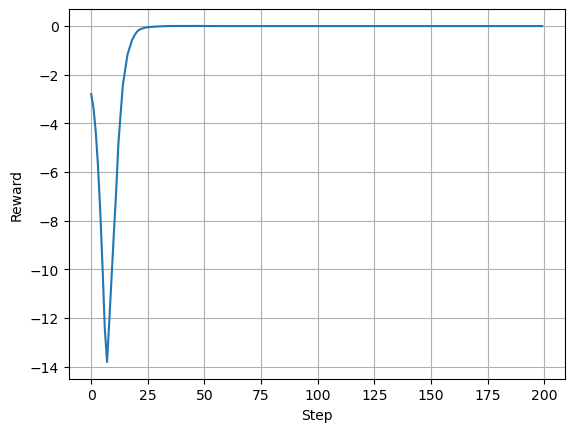

In [15]:
# 绘制奖励曲线
%matplotlib inline
plt.plot(rewards_history[1])
plt.xlabel('Step')
plt.ylabel('Reward')
# 网格线
plt.grid(True)
plt.show()